# Data Preprocessing

In [1]:
import pandas as pd

pd.set_option('future.no_silent_downcasting', True)


def get_valid_df(df: pd.DataFrame) -> pd.DataFrame:
    valid_ids = (
        df.groupby("ID")["TrialInfo"]
        .nunique()
        .loc[lambda x: x == 4]  # Only keep IDs with all 4 unique TrialInfo values
        .index
    )

    # Step 2: Filter the original dataframe
    filtered_df = df[df["ID"].isin(valid_ids)]

    df_valid = filtered_df.reset_index(drop=True)
    return df_valid.copy()


def transform_VR_in_long_format(must_catch: bool) -> pd.DataFrame:
    df = pd.read_csv('./data/EntgegenFangen.csv')

    # filter out all rows where - is in date
    df = df[~df["Date"].str.contains(" - ")]

    # make Date to datetime
    df["Date"] = pd.to_datetime(df["Date"].str.strip(), format="%Y-%m-%d %H:%M:%S")

    # rename the columns
    df.rename(columns={"Success": "Catch"}, inplace=True)

    date_to_number_map = {
        "2025-02-12": 1,
        "2025-02-13": 1,
        "2025-02-19": 2,
        "2025-02-20": 2,
        "2025-02-26": 3,
        "2025-02-27": 3,
        "2025-03-05": 4,
        "2025-03-06": 4,
    }

    df['DayOnly'] = df['Date'].dt.date
    # replace date with number
    df['TrialInfo'] = df['DayOnly'].astype(str).map(date_to_number_map)

    df["Catch"] = df["Catch"].str.strip().replace({"True": True, "False": False})
    # Filter out where Catch = False
    if must_catch:
        df = df[df["Catch"] == True]

    df = df.sort_values(by=['ID', 'TrialInfo'])

    # keep only the last 5 trials for each ID per Date
    df = df.groupby(['ID', 'TrialInfo']).tail(5)

    df['TrialIndex'] = df.groupby('ID').cumcount() + 1

    # Make Direction and Degree numeric
    df["Distance"] = df["Distance"].str.strip().str.replace(",", ".").astype(float)
    df["TrialInfo"] = df["TrialInfo"].astype(int)

    # drop StrenghValue, Source and DayOnly
    df.drop(columns=["Source", "Fall Velocity", "Pass Time", "DayOnly", "Date"], inplace=True)

    df = df[['ID', 'TrialIndex', 'TrialInfo', 'Catch', "Distance"]]

    df.reset_index(drop=True, inplace=True)

    # do min max normalization for Distance
    df["Distance"] = (df["Distance"] - df["Distance"].min()) / (df["Distance"].max() - df["Distance"].min())

    return df.copy()


def make_long(df: pd.DataFrame, group: str, must_catch: bool) -> pd.DataFrame:
    rep_date_pairs = [
        ('Gefangen 1', "Abstand Rückpass 1", 'Datum 1'),
        ('Gefangen 2', "Abstand Rückpass 2", 'Datum 2'),
        ('Gefangen 3', "Abstand Rückpass 3", 'Datum 3'),
        ('Gefangen 4', "Abstand Rückpass 4", 'Datum 4'),
    ]

    records = []

    for catch_col, distance_col, date_col in rep_date_pairs:
        for idx, row in df.iterrows():
            name = row['Name']
            catch = row[catch_col]
            distance = row[distance_col]
            date = row[date_col]

            if pd.notnull(catch):
                trial_info = f"{date.strip()}2025"
                records.append((name, catch, distance, trial_info))

    # Create the long-format DataFrame
    df_long = pd.DataFrame(records, columns=['Name', 'Catch', "Distance", 'TrialInfo'])

    # Add continuous trial index per participant
    df_long['TrialIndex'] = df_long.groupby('Name').cumcount() + 1

    # Reorder columns
    df_result = df_long[['Name', 'TrialIndex', 'TrialInfo', 'Catch', "Distance"]]
    df_result = df_result.rename(columns={"Name": "ID"})

    # Convert ID to int and Repetitions to float
    df_result["ID"] = df_result["ID"].str.extract(r"(\d+)").astype(int)

    # Convert the TrialInfo column to datetim
    df_result["TrialInfo"] = pd.to_datetime(df_result["TrialInfo"], format="%d.%m.%Y")

    # Transform "Catch" column to boolean, Ja = True, Nein = False
    df_result["Catch"] = df_result["Catch"].str.strip().replace({"Ja": True, "Nein": False, "ja": True, "nein": False})

    if must_catch:
        df_result = df_result[df_result["Catch"] == True]

    # So I will convert the TrialInfo column to a number that tells me the order of the trials.
    date_to_number_map = {
        "Kontrollgruppe": {
            "26.02.2025": 1,
            "05.03.2025": 2,
            "12.03.2025": 3,
            "19.03.2025": 4,
        },
        "RL 7e": {
            "11.02.2025": 1,
            "18.02.2025": 2,
            "25.02.2025": 3,
            "04.03.2025": 4,
        },
        "RL 7f": {
            "05.03.2025": 1,
            "12.03.2025": 2,
            "19.03.2025": 3,
            "26.03.2025": 4,
        },
    }
    df_result["TrialInfo"] = df_result["TrialInfo"].dt.strftime("%d.%m.%Y")
    df_result["TrialInfo"] = df_result["TrialInfo"].map(date_to_number_map[group])

    # do min max normalization for Distance
    df_result["Distance"] = (df_result["Distance"] - df_result["Distance"].min()) / (
            df_result["Distance"].max() - df_result["Distance"].min())

    # sprt by ID and TrialIndex
    df_result = df_result.sort_values(by=["ID", "TrialInfo"])

    return df_result.copy()

In [3]:
groups = ["Kontrollgruppe", "RL 7e", "RL 7f", "VR"]
exercise = 4
dfs = []
for must_catch in [True, False]:
    for group in groups:
        print("Processing group:", group, "sheet:", exercise)
        if group == "VR":
            df_long = transform_VR_in_long_format(must_catch)
        else:
            df = pd.read_excel(f"data/{group}.xlsx", sheet_name=exercise - 1)
            # Anonymize the data
            df["Name"] = df["Name"].str.extract(r"\((\d+)\)")
            df = df.dropna(subset=["Name"])

            # make the long format
            df_long = make_long(df, group, must_catch)

        df_long["Group"] = group

        # remove rows where Reset is in one of the columns
        df_long = df_long[~df_long.apply(lambda x: x.astype(str).str.contains("Reset").any(), axis=1)]

        dfs.append(df_long)

    # Concatenate the second and last
    df_merged = pd.concat(dfs, ignore_index=True)
    df_merged = df_merged.reset_index(drop=True)

    # Save the concatenated DataFrame to a CSV file
    df_merged.to_csv(f"data/Exercise_{exercise}_all_catched_{must_catch}.csv", index=False)

    df = get_valid_df(df_merged)
    df.to_csv(f"data/Exercise_{exercise}_valid_catched_{must_catch}.csv", index=False)

Processing group: Kontrollgruppe sheet: 4
Processing group: RL 7e sheet: 4
Processing group: RL 7f sheet: 4
Processing group: VR sheet: 4
Processing group: Kontrollgruppe sheet: 4
Processing group: RL 7e sheet: 4
Processing group: RL 7f sheet: 4
Processing group: VR sheet: 4


# Analysis and Plots

In [2]:
import random
from matplotlib import pyplot as plt


def plot_improvement_over_time(df: pd.DataFrame, exercise=4):
    # merge group RL 7C and RL 7g to RL. So that we only have groups VR, RL and Kontrollgruppe
    df["Group"] = df["Group"].replace({"RL 7e": "RL", "RL 7f": "RL"})
    #df["Catch"] = df["Catch"].replace({"True": 1, "False": 0})
    df.Catch = df.Catch.astype(int)
    df["Distance"] = df.Distance.astype(float)

    df_days = df.groupby(["ID", "TrialInfo"]).agg(
        Mean_Distance=("Distance", "mean"),
        Mean_Catch=("Catch", "mean"),
        Group=("Group", "first"),
        Gender=("Gender", "first")
    ).reset_index()

    for objective in ["Mean_Distance", "Mean_Catch"]:
        print("----------------------", objective, "----------------------")
        # Pivot to have one row per participant with Day 1 to 4 as columns
        df_pivot = df_days.pivot(index=["ID", "Group", "Gender"], columns="TrialInfo", values=objective).reset_index()
        df_pivot.columns.name = None  # clean up multi-index

        # Rename trial day columns
        df_pivot = df_pivot.rename(columns={
            1: "Day1",
            2: "Day2",
            3: "Day3",
            4: "Day4"
        })

        # List of days in order
        days = ["Day1", "Day2", "Day3", "Day4"]

        # Prepare data for plotting

        x = range(1, 5)  # x-axis positions for Day1 to Day4

        plt.figure(figsize=(12, 6))

        plt.xticks(x)

        groups = df_pivot["Group"].unique()
        genders = df_pivot["Gender"].unique()

        color_map = {
            "VR": "tab:blue",
            "RL": "tab:orange",
            "Kontrollgruppe": "tab:green"
        }
        alpha_map = {
            "m": 0.5,  # solid
            "w": 0.5  # lighter
        }
        linestyle_map = {
            "m": "--",  # solid
            "w": "--"  # dashed
        }
        marker_map = {
            "m": "o",  # solid
            "w": "d"  # dashed
        }

        for group in groups:
            group_data = df_pivot[df_pivot["Group"] == group]
            group_means = group_data[days].mean()
            group_stds = group_data[days].std()  # <- Standard Error of the Mean(means)

            label_str = "KG" if group == "Kontrollgruppe" else group.upper()

            print(f"{label_str} (gesamt)")
            print(f"#Teilnehmer gesamt:", len(group_data))
            print(f"Messzeitpunkt 1: {round(group_means.iloc[0], 3)} +- {round(group_stds.iloc[0], 3)}")
            print(f"Messzeitpunkt 4: {round(group_means.iloc[3], 3)} +- {round(group_stds.iloc[3], 3)}")
            plt.errorbar(
                x, group_means, yerr=group_stds,
                label=f"{label_str} (gesamt)",
                capsize=5, marker='x', linestyle='-',
                color=color_map[group], linewidth=1.5,
            )

            # Plot gender-specific means (same group color, different style)
            for gender in genders:
                gender_data = group_data[group_data["Gender"] == gender]
                if gender_data.empty:
                    continue
                means = gender_data[days].mean()
                stds = gender_data[days].std()

                print(f"{label_str} ({gender})")
                print(f"#Teilnehmer {gender}:", len(gender_data))
                print(f"Messzeitpunkt 1: {round(means.iloc[0], 3)} +- {round(stds.iloc[0], 3)}")
                print(f"Messzeitpunkt 4: {round(means.iloc[3], 3)} +- {round(stds.iloc[3], 3)}")

                label = f"{label_str} ({gender})"
                plt.errorbar(
                    x, means, yerr=stds,
                    label=label,
                    capsize=4,
                    marker=marker_map[gender],
                    linestyle=linestyle_map[gender],
                    color=color_map[group],
                    alpha=alpha_map[gender],
                    linewidth=1,
                )

        plt.xlabel("Messzeitpunkt")
        plt.ylim(bottom=0)
        y_label = "Durchschnittliche Fangrate" if objective == "Mean_Catch" else "Durchschnittliche Distanz"
        plt.ylabel(y_label)
        title_str = "Distanz" if objective == "Mean_Distance" else "Fangrate"
        plt.title(f"{title_str} Übung {exercise}", fontsize=14, fontweight='bold', pad=20)
        plt.legend(title="Gruppe", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig(f"./figures/Übung 4/improvement_over_time_{title_str}_{exercise}.png", dpi=300)
        plt.show()


def plot_results_per_ID_within_group(df: pd.DataFrame, exercise=4):
    df["Catch"] = df["Catch"].replace({"True": 1, "False": 0})
    df.Catch = df.Catch.astype(int)
    df["Group"] = df["Group"].replace({"RL 7e": "RL", "RL 7f": "RL"})
    df["Distance"] = df.Distance.astype(float)

    df_days = df.groupby(["ID", "TrialInfo"]).agg(
        Mean_Distance=("Distance", "mean"),
        Mean_Catch=("Catch", "mean"),
        Group=("Group", "first")
    ).reset_index()

    for group in df["Group"].unique():
        group_data = df_days[df_days["Group"] == group]
        unique_ids = list(group_data["ID"].unique())
        if len(unique_ids) >= 10:
            random_10_ids = random.sample(unique_ids, 10)
        else:
            random_10_ids = unique_ids  # Just take all of them

        for objective in ["Mean_Distance", "Mean_Catch"]:
            plt.figure(figsize=(12, 6))
            unique_dates = group_data["TrialInfo"].unique()
            plt.xticks(unique_dates, unique_dates)

            for participant in unique_ids:
                participant_data = group_data[group_data["ID"] == participant]
                if participant_data["TrialInfo"].nunique() == 4:
                    plt.plot(participant_data["TrialInfo"], participant_data[objective], marker='x', label=participant)
                else:
                    plt.plot(participant_data["TrialInfo"], participant_data[objective], linestyle='--', color='gray',
                             alpha=0.20, label="_nolegend_")

            plt.xlabel("Messzeitpunkt")
            y_label = "Durchschnittliche Fangrate" if objective == "Mean_Catch" else "Durchschnittliche Distanz"
            plt.ylabel(y_label)
            plt.ylim(bottom=0)
            title_str = "Distanz" if objective == "Mean_Distance" else "Fangrate"
            plt.title(f"{group.capitalize()}: {title_str} Übung {exercise}", fontsize=14, fontweight='bold', pad=20)
            # Legend below the plot
            plt.legend(
                title="ID",
                loc="upper center",
                bbox_to_anchor=(0.5, -0.25),
                ncol=11,  # Adjust depending on how many columns you want
                fontsize=8,
                title_fontsize=10
            )
            plt.grid(axis='y', linestyle='--', alpha=0.25)
            plt.tight_layout()
            plt.savefig("./figures/Übung 4/individual_results_per_ID_{}_{}_{}.png".format(group, objective, exercise),
                        dpi=300)
            plt.show()

---------------------- Mean_Distance ----------------------
VR (gesamt)
#Teilnehmer gesamt: 2
Messzeitpunkt 1: 0.071 +- 0.025
Messzeitpunkt 4: 0.199 +- 0.157
VR (m)
#Teilnehmer m: 2
Messzeitpunkt 1: 0.071 +- 0.025
Messzeitpunkt 4: 0.199 +- 0.157
RL (gesamt)
#Teilnehmer gesamt: 28
Messzeitpunkt 1: 0.237 +- 0.23
Messzeitpunkt 4: 0.087 +- 0.128
RL (m)
#Teilnehmer m: 17
Messzeitpunkt 1: 0.267 +- 0.201
Messzeitpunkt 4: 0.087 +- 0.101
RL (w)
#Teilnehmer w: 11
Messzeitpunkt 1: 0.191 +- 0.273
Messzeitpunkt 4: 0.088 +- 0.168
KG (gesamt)
#Teilnehmer gesamt: 6
Messzeitpunkt 1: 0.171 +- 0.151
Messzeitpunkt 4: 0.18 +- 0.283
KG (m)
#Teilnehmer m: 6
Messzeitpunkt 1: 0.171 +- 0.151
Messzeitpunkt 4: 0.18 +- 0.283


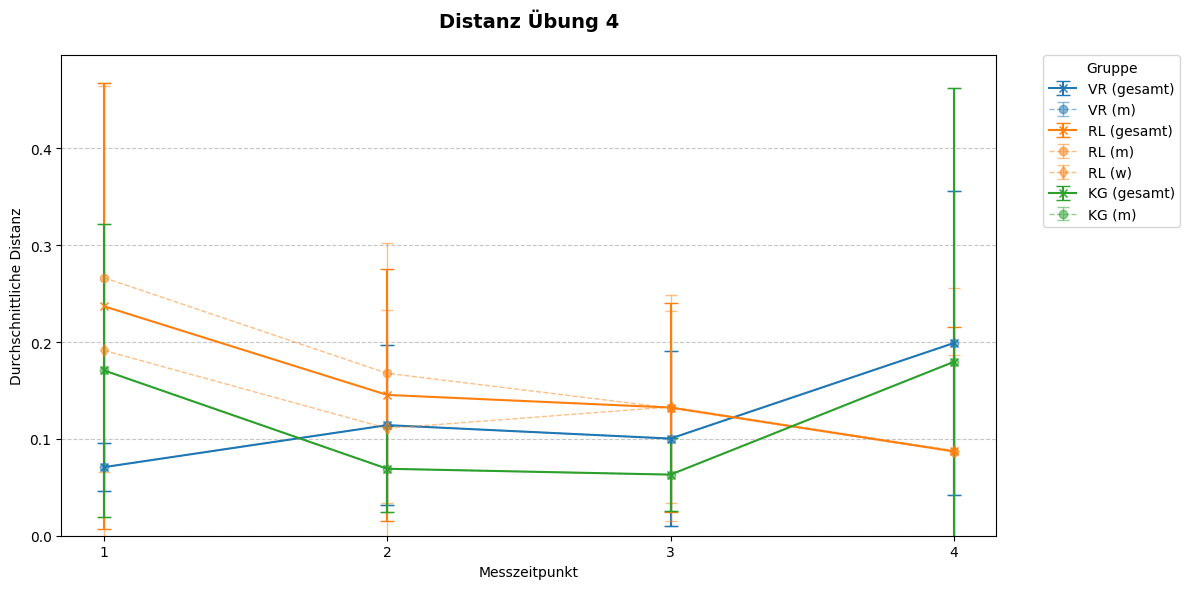

---------------------- Mean_Catch ----------------------
VR (gesamt)
#Teilnehmer gesamt: 2
Messzeitpunkt 1: 1.0 +- 0.0
Messzeitpunkt 4: 1.0 +- 0.0
VR (m)
#Teilnehmer m: 2
Messzeitpunkt 1: 1.0 +- 0.0
Messzeitpunkt 4: 1.0 +- 0.0
RL (gesamt)
#Teilnehmer gesamt: 28
Messzeitpunkt 1: 1.0 +- 0.0
Messzeitpunkt 4: 1.0 +- 0.0
RL (m)
#Teilnehmer m: 17
Messzeitpunkt 1: 1.0 +- 0.0
Messzeitpunkt 4: 1.0 +- 0.0
RL (w)
#Teilnehmer w: 11
Messzeitpunkt 1: 1.0 +- 0.0
Messzeitpunkt 4: 1.0 +- 0.0
KG (gesamt)
#Teilnehmer gesamt: 6
Messzeitpunkt 1: 1.0 +- 0.0
Messzeitpunkt 4: 1.0 +- 0.0
KG (m)
#Teilnehmer m: 6
Messzeitpunkt 1: 1.0 +- 0.0
Messzeitpunkt 4: 1.0 +- 0.0


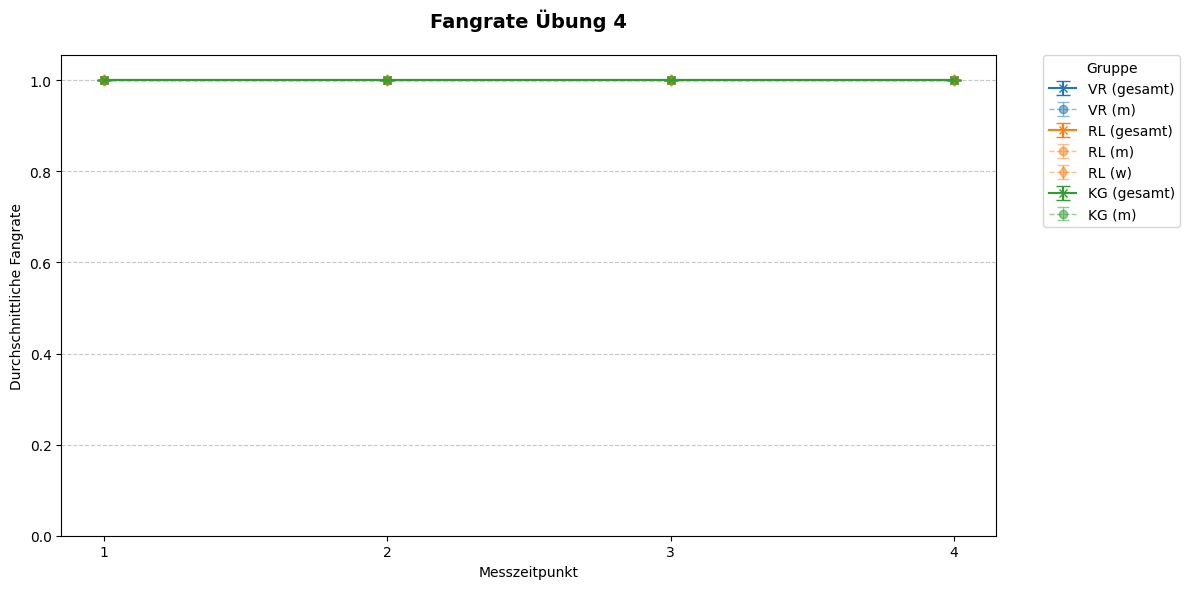

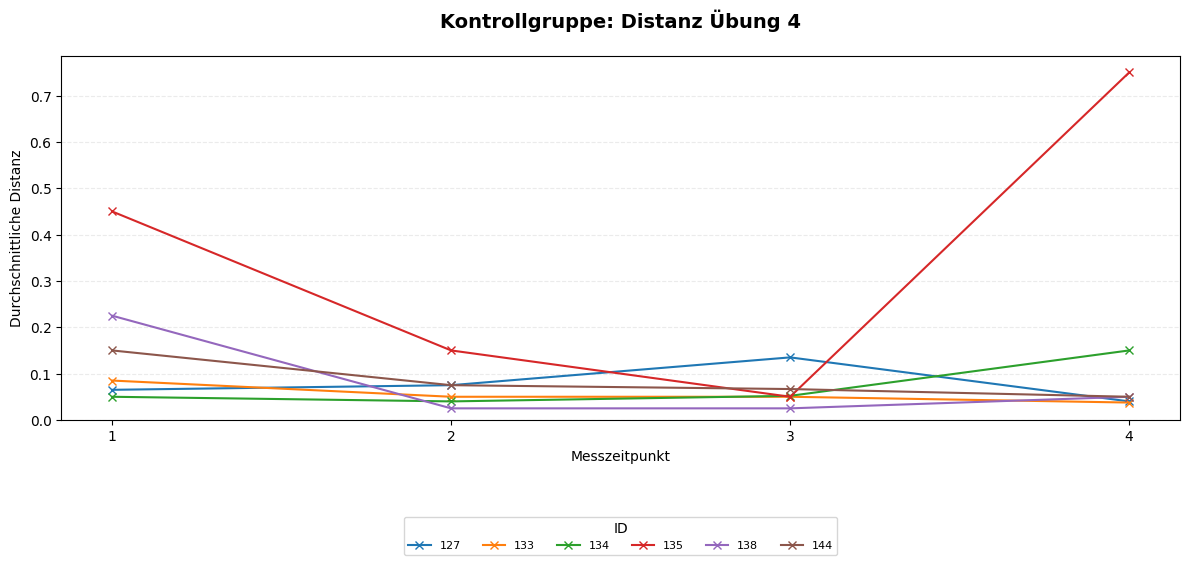

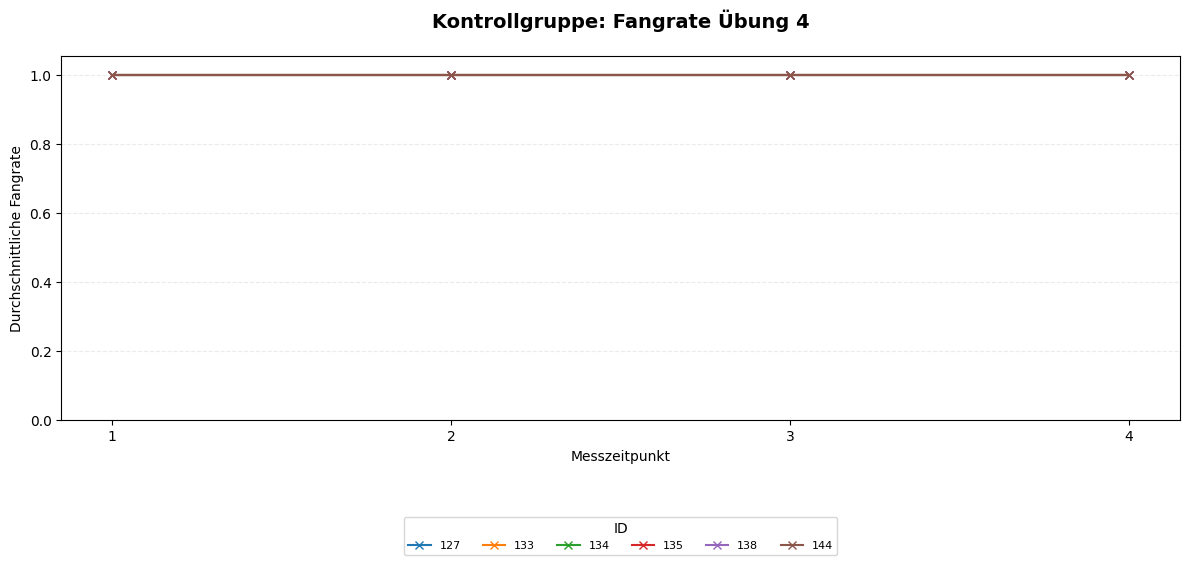

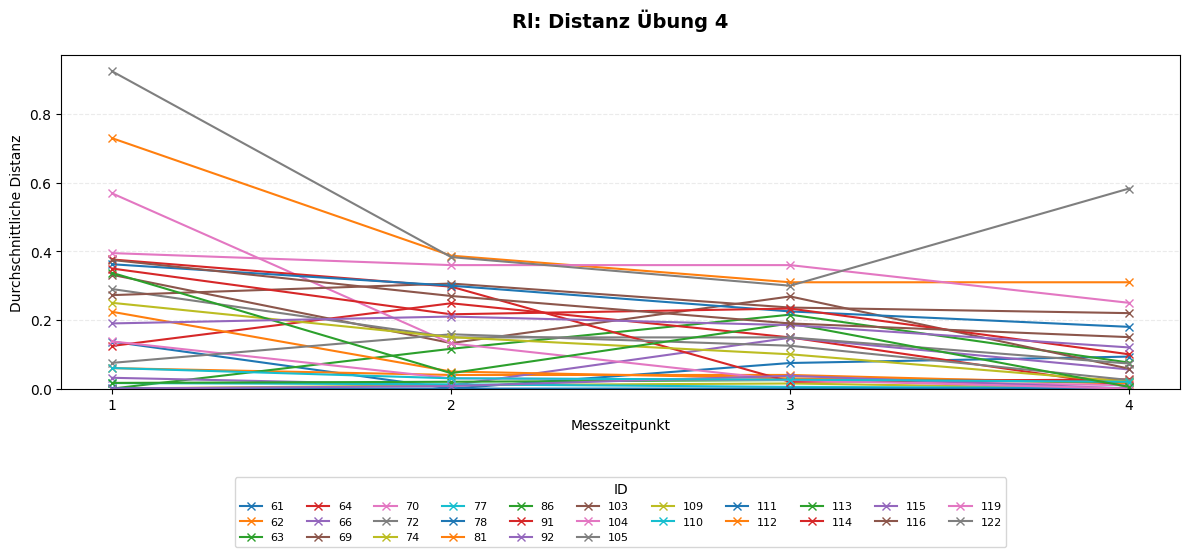

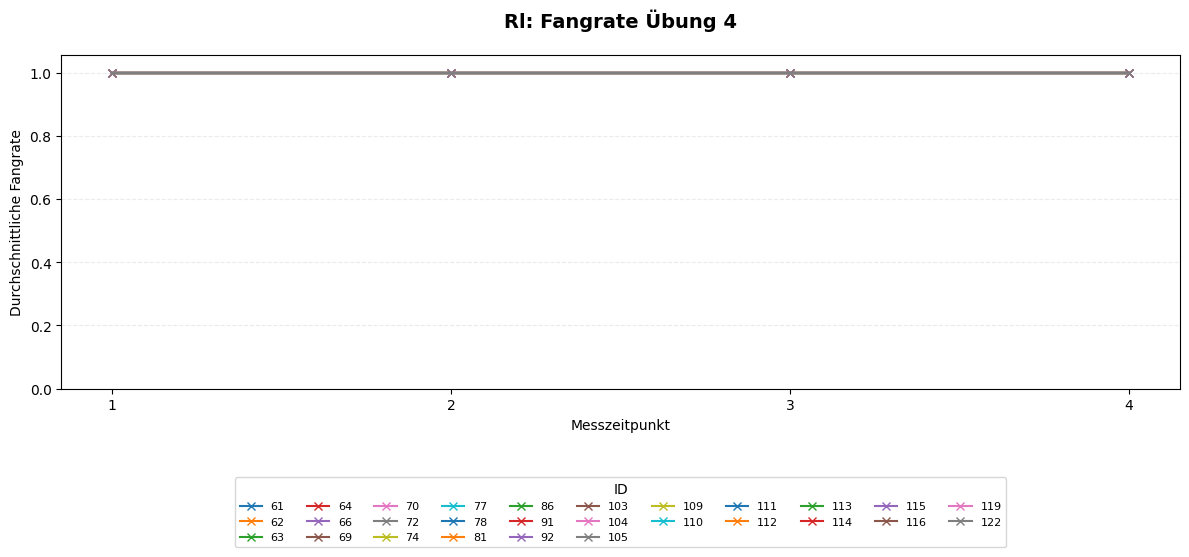

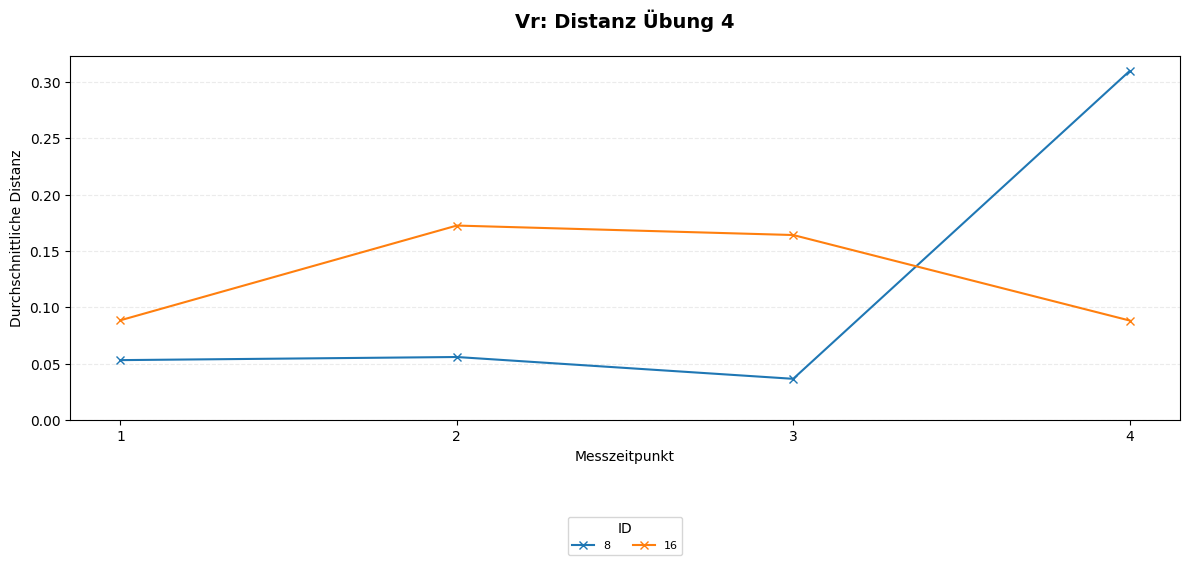

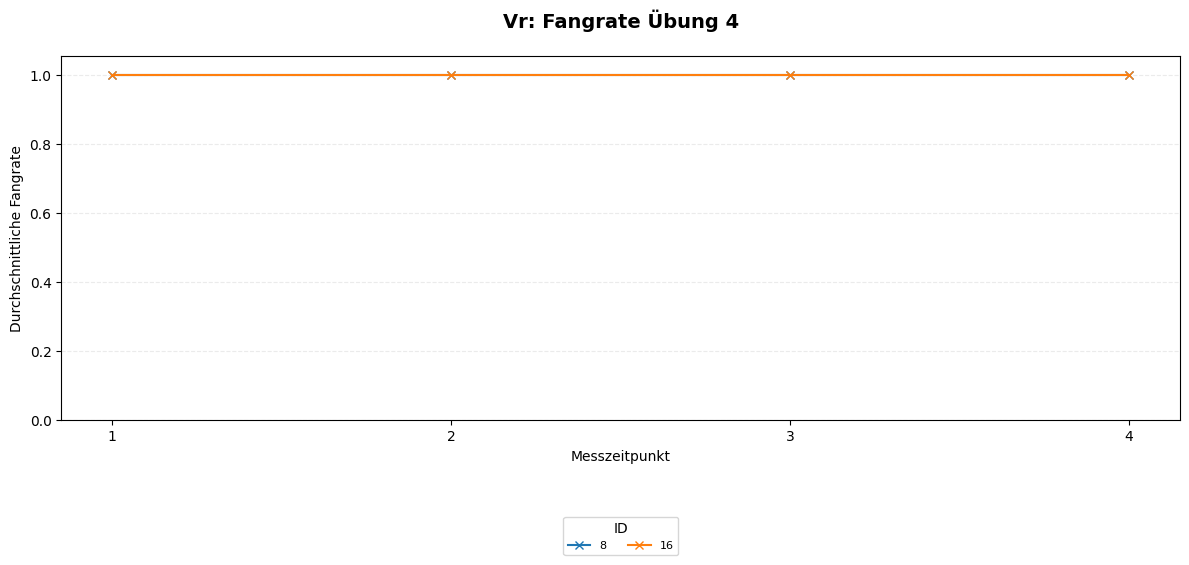

In [6]:
configuration = ("valid_catched_True")

df = pd.read_csv(f"data/Exercise_4_{configuration}.csv")
groups = ["Kontrollgruppe", "RL 7e", "RL 7f", "VR"]

# Load gender data: ID, gender
df_gender = pd.read_csv("data/gender.csv")
# add gender to the df
df = pd.merge(df, df_gender, on="ID", how="left")

plot_improvement_over_time(df.copy())
plot_results_per_ID_within_group(df.copy())